<!-- Updated Summary: Hybrid Botnet Detection using GA and LightGBM -->

# Hybrid Botnet Detection using GA and LightGBM

This project implements a comprehensive pipeline for detecting botnet attacks in network traffic using a combination of Genetic Algorithms (GA) for feature selection and LightGBM for classification. The main steps include:

1. **Data Import & Cleaning:**  
   - Loads multiple CSV files containing network traffic data.  
   - Concatenates the data into a single DataFrame, removes duplicates, cleans column names, replaces infinity values, and fills in missing data (using means for numeric features and modes for categorical ones).  
   - Drops constant columns that don't contribute useful information.

2. **Data Splitting & Preprocessing:**  
   - Separates the cleaned data into stratified training and test sets.  
   - Encodes categorical variables (e.g., protocol flags) using techniques such as Label Encoding and One-Hot Encoding.  
   - Addresses class imbalance using SMOTE and scales features via MinMaxScaler.

3. **Feature Selection via Genetic Algorithm (GA):**  
   - Represents feature subsets as binary vectors in the GA framework (using DEAP).  
   - Each individual is evaluated by training a LightGBM classifier on a random subsample of the training data.  
   - GA operations (crossover, mutation, selection) are applied over multiple generations, with fitness measured by model accuracy.  
   - The GA records and reports fitness progress to determine the best subset of features.

4. **Final Model Training & Evaluation:**  
   - Trains a final LightGBM model with early stopping using only the GA-selected features.  
   - Uses 5-fold cross-validation to compute evaluation metrics, including Accuracy, Precision, Recall, F1 Score, AUC, Log Loss, and the Matthews Correlation Coefficient (MCC), along with confusion matrices.
   - Evaluates the model on an unseen test set and visualizes performance metrics with ROC curves, precision-recall curves, and heatmaps.

This summary encapsulates the integrated approach, combining robust preprocessing, advanced feature selection with evolutionary algorithms, and state-of-the-art model training to achieve high-performance botnet detection.

In [1]:
# Cell 1: Import Required Packages
import numpy as np
import pandas as pd
import joblib
import json
import os
import random
import time
import logging
import os
import glob 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from imblearn.over_sampling import SMOTE  
from deap import base, creator, tools
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler  
from imblearn.over_sampling import SMOTE # For handling imbalanced datasets

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, log_loss, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import KFold, StratifiedKFold, learning_curve 



In [4]:
# Directory containing all 4 files
data_dir = "data_files/bot_iot"


filenames = [
    "UNSW_2018_IoT_Botnet_Full5pc_1.csv",
    "UNSW_2018_IoT_Botnet_Full5pc_2.csv",
    "UNSW_2018_IoT_Botnet_Full5pc_3.csv",
    "UNSW_2018_IoT_Botnet_Full5pc_4.csv"
]

df_list = [pd.read_csv(os.path.join(data_dir, file), low_memory=False) for file in filenames]
df = pd.concat(df_list, ignore_index=True)

#  Preview the combined DataFrame
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668522 entries, 0 to 3668521
Data columns (total 46 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   pkSeqID                           int64  
 1   stime                             float64
 2   flgs                              object 
 3   flgs_number                       int64  
 4   proto                             object 
 5   proto_number                      int64  
 6   saddr                             object 
 7   sport                             object 
 8   daddr                             object 
 9   dport                             object 
 10  pkts                              int64  
 11  bytes                             int64  
 12  state                             object 
 13  state_number                      int64  
 14  ltime                             float64
 15  seq                               int64  
 16  dur                               fl

In [ ]:
df.head()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1.528089e+09,e,1,tcp,1,192.168.100.147,49960,192.168.100.7,80,...,1.12704,96,75,1.133720,1.129970,770,602,1,DoS,HTTP
1,2,1.528089e+09,e,1,arp,2,192.168.100.7,-1,192.168.100.147,-1,...,15267.20000,1,2,0.005142,0.005142,2,6,1,DoS,HTTP
2,3,1.528089e+09,e,1,tcp,1,192.168.100.147,49962,192.168.100.7,80,...,1.12704,96,75,1.135100,1.129970,770,602,1,DoS,HTTP
3,4,1.528089e+09,e,1,tcp,1,192.168.100.147,49964,192.168.100.7,80,...,1.12704,96,75,1.135140,1.129970,770,602,1,DoS,HTTP
4,5,1.528089e+09,e,1,tcp,1,192.168.100.147,49966,192.168.100.7,80,...,1.12704,96,75,1.135260,1.129970,770,602,1,DoS,HTTP


In [ ]:
print("Dataframe shape:", df.shape)

Dataframe shape: (3668522, 46)


In [ ]:
# Data Processing

# Ensure df is loaded
if 'df' not in globals():
    raise NameError("Combined DataFrame 'df' not found.")

print("Original df shape:", df.shape)

# Remove duplicate rows
df_clean = df.drop_duplicates().copy()

# Clean column names: remove extra spaces
df_clean.columns = df_clean.columns.str.replace(" ", "").str.strip()

# Replace infinities with NaN
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values:
# For numeric columns, fill with the column mean.
numeric_cols = df_clean.select_dtypes(include=np.number).columns
for col in numeric_cols:
    df_clean[col].fillna(df_clean[col].mean(), inplace=True)

# For non-numeric columns, fill with the most frequent value (mode)
non_numeric_cols = df_clean.select_dtypes(exclude=np.number).columns
for col in non_numeric_cols:
    mode_val = df_clean[col].mode()
    df_clean[col].fillna(mode_val[0] if not mode_val.empty else "Unknown", inplace=True)

# Drop columns that contain only one unique value (constant columns)
constant_cols = [col for col in df_clean.columns if df_clean[col].nunique(dropna=False) == 1]
if constant_cols:
    df_clean.drop(columns=constant_cols, inplace=True)
    print("Dropped constant columns:", constant_cols)

print("Cleaned df shape:", df_clean.shape)

Original df shape: (3668522, 46)
Cleaned df shape: (3668522, 46)


In [ ]:
# Separating Data into Training and Test Sets

#UNIT TEST  to check if df_clean exists

if 'df_clean' not in globals():
    raise NameError("Cleaned DataFrame 'df_clean' not found. Please run the cleaning cell first.")

print("Cleaned df shape:", df_clean.shape)

# Ensure the target column exists in df_clean
target_col = 'attack'
if target_col not in df_clean.columns:
    raise KeyError(f"Target column '{target_col}' not found in df_clean.")

# Stratified split of the data (70% training, 30% test)
data_train, data_test = train_test_split(
    df_clean, test_size=0.3, stratify=df_clean[target_col], random_state=42
)

print("Training set shape:", data_train.shape)
print("Test set shape:", data_test.shape)

Cleaned df shape: (3668522, 46)
Training set shape: (2567965, 46)
Test set shape: (1100557, 46)


In [ ]:


# === Columns to drop: identifiers, categorical IPs/ports, protocol info, meta ===
columns_to_drop = [
    'pkSeqID', 'seq', 'stime', 'ltime',
    'saddr', 'daddr', 'sport', 'dport',
    'proto', 'state',
    'category', 'subcategory','flgs'
]

# === Preserve target labels ===
y_train = data_train['attack'].copy()
y_test = data_test['attack'].copy()

# === Drop irrelevant columns from feature sets ===
X_train = data_train.drop(columns=columns_to_drop + ['attack'], errors='ignore').copy()
X_test = data_test.drop(columns=columns_to_drop + ['attack'], errors='ignore').copy()

# === Store feature names for model reference ===
feature_names = X_train.columns.tolist()

# === Debug Info ===
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

print(f"\nUnique attack classes: {np.unique(y_train)}")
print("\nTraining class distribution:")
print(y_train.value_counts())
print("\nTesting class distribution:")
print(y_test.value_counts())


X_train shape: (2567965, 32)
y_train shape: (2567965,)
X_test shape:  (1100557, 32)
y_test shape:  (1100557,)

Unique attack classes: [0 1]

Training class distribution:
attack
1    2567631
0        334
Name: count, dtype: int64

Testing class distribution:
attack
1    1100414
0        143
Name: count, dtype: int64


In [ ]:
#Class Imbalance Handling (SMOTE) and Feature Scaling


# Unit Test: Ensure X_train, y_train, and X_test are defined and of correct types
if 'X_train' not in locals() or 'y_train' not in locals() or 'X_test' not in locals():
    raise NameError("X_train, y_train, or X_test not found. ")
if not isinstance(X_train, pd.DataFrame) or not isinstance(X_test, pd.DataFrame):
    raise TypeError("X_train or X_test are not Pandas DataFrames.")
if not isinstance(y_train, pd.Series):
    print("Warning: y_train is not a Pandas Series. Converting for SMOTE compatibility.")
    y_train = pd.Series(y_train)

print(f"--- Cell 5: Class Imbalance Handling (SMOTE) and Feature Scaling ---")
print(f"  Shape of X_train before SMOTE: {X_train.shape}, y_train before SMOTE: {y_train.shape}")
print(f"  Class distribution in y_train before SMOTE:\n{y_train.value_counts(normalize=True)}")

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
try:
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"\n  SMOTE applied to training data.")
    print(f"    Shape of X_train_resampled (after SMOTE): {X_train_resampled.shape}")
    print(f"    Shape of y_train_resampled (after SMOTE): {y_train_resampled.shape}")
    print(f"    Class distribution in y_train_resampled after SMOTE:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")
except Exception as e:
    print(f"ERROR during SMOTE: {e}")
    print("  Ensure X_train contains only numeric features and y_train is in the correct format.")
    raise

# Scale features using MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on resampled training data and transform it
X_train_scaled = scaler.fit_transform(X_train_resampled)
print(f"\n  MinMaxScaler fitted on X_train_resampled and applied.")
print(f"    Shape of X_train_scaled: {X_train_scaled.shape}")

# Transform X_test using the same scaler
X_test_scaled = scaler.transform(X_test)
# Clip X_test_scaled to keep its values within [0, 1]
if X_test_scaled.size > 0:
    X_test_scaled = np.clip(X_test_scaled, 0, 1)
print(f"  X_test scaled using the same fitted scaler.")
print(f"    Shape of X_test_scaled: {X_test_scaled.shape}")

print("\n--- Cell 5: SMOTE and Scaling Complete ---")

# --- Unit Test: SMOTE & Feature Scaling ---
print(f"\n--- Unit Test: SMOTE & Feature Scaling ---")
try:
    print("  Validating outputs of Cell 5...")
    # Validate SMOTE outputs
    assert 'X_train_resampled' in locals() and 'y_train_resampled' in locals(), \
        "X_train_resampled or y_train_resampled not created."
    assert X_train_resampled.shape[0] == y_train_resampled.shape[0], \
        "X_train_resampled and y_train_resampled have mismatched sample counts."
    assert X_train_resampled.shape[1] == X_train.shape[1], \
        "Number of features changed after SMOTE (should remain the same)."
    # Check class balance for binary classification
    if len(np.unique(y_train_resampled)) == 2:
        counts = pd.Series(y_train_resampled).value_counts()
        assert counts.iloc[0] == counts.iloc[1], \
            f"Classes in y_train_resampled are not balanced after SMOTE. Counts: {counts.to_dict()}"
        print("    Class balance in y_train_resampled confirmed (for binary).")
    else:
        print("    Warning: Balance check skipped for non-binary or single-class scenario.")
    print("    SMOTE output validation passed.")

    # Validate Scaler outputs
    assert 'X_train_scaled' in locals() and 'X_test_scaled' in locals(), \
        "X_train_scaled or X_test_scaled not created."
    assert X_train_scaled.shape == X_train_resampled.shape, \
        "Shape of X_train_scaled does not match X_train_resampled."
    assert X_test_scaled.shape[1] == X_test.shape[1], \
        "Number of features in X_test_scaled does not match original X_test."
    assert X_test_scaled.shape[0] == X_test.shape[0], \
        "Number of samples in X_test_scaled does not match original X_test."
    assert np.all(X_train_scaled >= 0) and np.all(X_train_scaled <= 1), \
        "Values in X_train_scaled are not within the [0, 1] range."
    # For X_test_scaled, after clipping, they must be within [0, 1]
    if X_test_scaled.size > 0:
        assert np.all(X_test_scaled >= 0) and np.all(X_test_scaled <= 1), \
            "Clipped values in X_test_scaled are not within the [0, 1] range."
    print("    Scaler output validation (shapes, ranges) passed.")

    # Check that scaler attributes are present
    assert hasattr(scaler, 'min_') and scaler.min_ is not None, "Scaler (MinMaxScaler) was not fitted (missing 'min_')."
    assert hasattr(scaler, 'scale_') and scaler.scale_ is not None, "Scaler (MinMaxScaler) was not fitted (missing 'scale_')."
    print("    Scaler fitting confirmed.")

    print("All validations for SMOTE and Normalisation passed.")
except NameError as e:
    print(f"VALIDATION FAILED for Cell 5 (NameError): {e}")
    print("   This likely means an input variable (e.g., X_train) was not available from Cell 4.")
    raise
except AssertionError as e:
    print(f"VALIDATION FAILED for Cell 5: {e}")
    raise

--- Cell 5: Class Imbalance Handling (SMOTE) and Feature Scaling ---
  Shape of X_train before SMOTE: (2567965, 32), y_train before SMOTE: (2567965,)
  Class distribution in y_train before SMOTE:
attack
1    0.99987
0    0.00013
Name: proportion, dtype: float64

  SMOTE applied to training data.
    Shape of X_train_resampled (after SMOTE): (5135262, 32)
    Shape of y_train_resampled (after SMOTE): (5135262,)
    Class distribution in y_train_resampled after SMOTE:
attack
1    0.5
0    0.5
Name: proportion, dtype: float64

  MinMaxScaler fitted on X_train_resampled and applied.
    Shape of X_train_scaled: (5135262, 32)
  X_test scaled using the same fitted scaler.
    Shape of X_test_scaled: (1100557, 32)

--- Cell 5: SMOTE and Scaling Complete ---

--- Unit Test: SMOTE & Feature Scaling ---
  Validating outputs of Cell 5...
    Class balance in y_train_resampled confirmed (for binary).
    SMOTE output validation passed.
    Scaler output validation (shapes, ranges) passed.
    Scal

Gen 1: Best Individual Features: ['flgs_number', 'proto_number', 'state_number', 'stddev', 'spkts', 'sbytes', 'rate', 'srate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_Sport', 'Pkts_P_State_P_Protocol_P_SrcIP'] (Fitness: 0.9999834478)
Gen 1/20 | Avg Fitness: 0.9998524904 | Max Fitness: 0.9999834478 | Time: 53.20s
Gen 2: Best Individual Features: ['flgs_number', 'proto_number', 'stddev', 'max', 'spkts', 'sbytes', 'rate', 'srate', 'TnBPSrcIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_DstIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_SrcIP'] (Fitness: 0.9999815004)
Gen 2/20 | Avg Fitness: 0.9999719586 | Max Fitness: 0.9999815004 | Time: 25.42s
Gen 3: Best Individual Features: ['flgs_number', 'proto_number', 'mean', 'max', 'spkts', 'sbytes', 'dbytes', 'rate', 'srate', 'TnBPSrcIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_

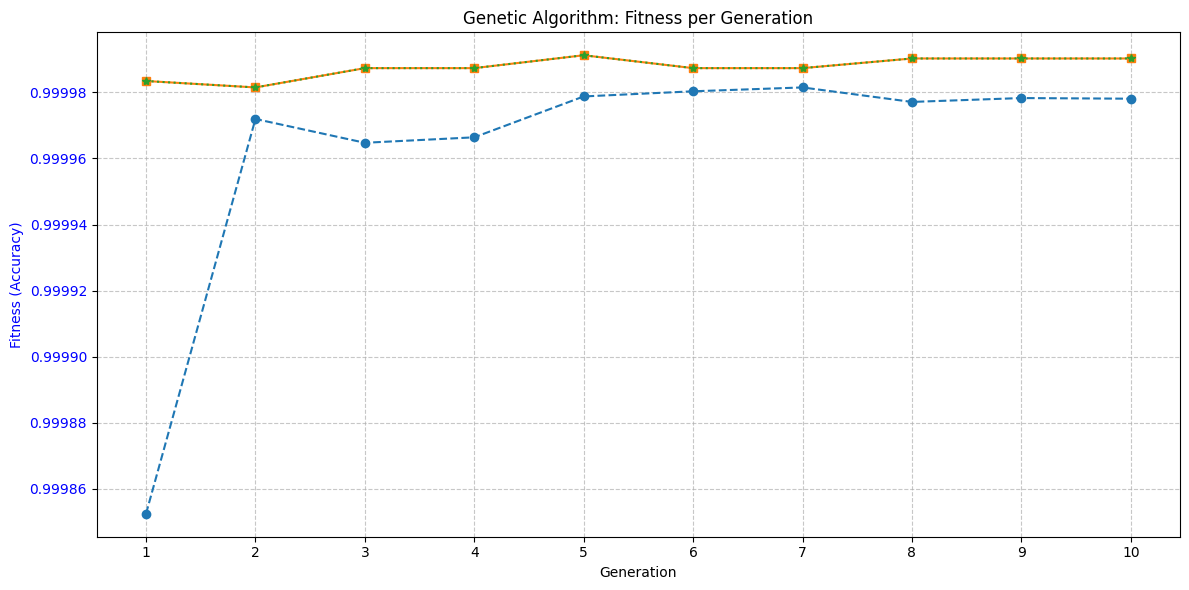

Genetic Algorithm execution complete.


In [ ]:

# Validate required variables
if 'X_train_scaled' not in locals() or 'y_train_resampled' not in locals() or 'feature_names' not in locals():
    raise NameError("X_train_scaled, y_train_resampled, or feature_names not found. Please run the preceding cells first.")
if not isinstance(feature_names, list):
    raise TypeError("feature_names is not a list.")
if X_train_scaled.shape[1] != len(feature_names):
    raise ValueError(f"Mismatch: X_train_scaled has {X_train_scaled.shape[1]} features but feature_names has {len(feature_names)} entries.")

# Clear previous DEAP creator definitions (if any)
try:
    del creator.FitnessMax
except AttributeError:
    pass
try:
    del creator.Individual
except AttributeError:
    pass

# Create DEAP fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
num_features = X_train_scaled.shape[1]
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# GA Hyperparameters
population_size = 10
n_generations = 20
crossover_prob = 0.9
mutation_prob = 0.5
mutation_indpb = 0.1
patience = 5
min_features_constraint = 5

# LightGBM parameters for GA evaluation (simplified for speed)
lgb_params_ga = {
    "learning_rate": 0.07,
    "num_leaves": 16,
    "max_depth": 8,
    "min_child_samples": 50,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "n_estimators": 50,
    "verbose": -1,
    "n_jobs": -1,
    "random_state": 42
}

fitness_cache = {}

def evaluate_individual_ga(individual, eval_fraction=0.2):
    """Evaluate an individual (feature subset) using a LightGBM model on a subsample of data."""
    key = tuple(individual)
    if key in fitness_cache:
        return fitness_cache[key]
    
    # Get indices where the feature is selected
    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
    # Enforce minimum number of features constraint
    if len(selected_indices) < min_features_constraint:
        fitness_cache[key] = (0.01,)
        return (0.01,)
    
    y_target = np.array(y_train_resampled)
    total_samples = X_train_scaled.shape[0]
    if total_samples != len(y_target):
        raise ValueError("Mismatch between X_train_scaled and y_train_resampled sample counts.")
    
    n_samples = max(int(total_samples * eval_fraction), 200)
    n_samples = min(n_samples, total_samples)
    if n_samples <= 0:
        fitness_cache[key] = (0.005,)
        return (0.005,)
    
    subset_indices = np.random.choice(total_samples, size=n_samples, replace=False)
    X_subset = X_train_scaled[subset_indices][:, selected_indices]
    y_subset = y_target[subset_indices]
    
    try:
        model = lgb.LGBMClassifier(**lgb_params_ga)
        model.fit(X_subset, y_subset)
        y_pred = model.predict(X_subset)
        fitness_metric = accuracy_score(y_subset, y_pred)
        fitness = max(fitness_metric, 0.01)
        fitness_cache[key] = (fitness,)
        return (fitness,)
    except Exception as e:
        fitness_cache[key] = (0.01,)
        return (0.01,)

toolbox.register("evaluate", evaluate_individual_ga)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=mutation_indpb)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population and GA statistics
population = toolbox.population(n=population_size)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
logbook = tools.Logbook()

ga_fitness_progress = {"avg": [], "max": [], "best_overall": []}
best_features_per_generation_log = []
best_fitness_overall = 0.0
stagnation_count = 0

for gen in range(n_generations):
    start_gen = time.time()
    
    # Selection and cloning
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    # Crossover and mutation; remove fitness to force re-evaluation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < crossover_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        if random.random() < mutation_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Re-evaluate individuals with invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox.evaluate(ind)
    
    # Replace population with offspring
    population[:] = offspring
    record = stats.compile(population)
    ga_fitness_progress["avg"].append(record["avg"])
    ga_fitness_progress["max"].append(record["max"])
    current_best = record["max"]
    ga_fitness_progress["best_overall"].append(current_best)
    
    best_ind = tools.selBest(population, k=1)[0]
    if best_ind.fitness.valid:
        selected_indices = [i for i, bit in enumerate(best_ind) if bit == 1]
        current_feature_names = [feature_names[i] for i in selected_indices if i < len(feature_names)]
        best_features_per_generation_log.append({
            "generation": gen + 1,
            "fitness": best_ind.fitness.values[0],
            "num_features": len(current_feature_names),
            "feature_names": current_feature_names
        })
        print(f"Gen {gen+1}: Best Individual Features: {current_feature_names} (Fitness: {best_ind.fitness.values[0]:.10f})")
    
    end_gen = time.time()
    print(f"Gen {gen+1}/{n_generations} | Avg Fitness: {record['avg']:.10f} | Max Fitness: {record['max']:.10f} | Time: {end_gen - start_gen:.2f}s")
    
    if current_best > best_fitness_overall:
        best_fitness_overall = current_best
        stagnation_count = 0
    else:
        stagnation_count += 1
    if stagnation_count >= patience:
        print(f"Stopping early at generation {gen+1} after {patience} generations of stagnation.")
        break

final_gen_count = gen + 1
best_individual = tools.selBest(population, k=1)[0]
selected_feature_indices_ga = [i for i, bit in enumerate(best_individual) if bit == 1]
try:
    selected_feature_names_ga = [feature_names[i] for i in selected_feature_indices_ga]
except IndexError:
    selected_feature_names_ga = [f"feature_{i}" for i in selected_feature_indices_ga]

print("\n--- Genetic Algorithm Summary ---")
print(f"Total Generations Run: {final_gen_count}")
print(f"Best Fitness Achieved: {best_individual.fitness.values[0]:.10f}")
print(f"Number of Features Selected: {len(selected_feature_names_ga)} (out of {num_features})")
if selected_feature_names_ga:
    print("Selected Features:")
    for feat in selected_feature_names_ga:
        print(f"  - {feat}")
else:
    print("Warning: No features selected (or min feature constraint not met).")

print("\n--- Best Feature Names Per Generation ---")
for rec in best_features_per_generation_log:
    print(f"Gen {rec['generation']}: Fitness={rec['fitness']:.10f}, Num Features={rec['num_features']}, Features={rec['feature_names']}")

# Plot fitness progress over generations
if ga_fitness_progress["avg"]:
    generations_plot = range(1, final_gen_count + 1)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(generations_plot, ga_fitness_progress["avg"], label="Avg Fitness", marker="o", linestyle="--")
    ax1.plot(generations_plot, ga_fitness_progress["max"], label="Max Fitness", marker="s", linestyle="-")
    ax1.plot(generations_plot, ga_fitness_progress["best_overall"], label="Best Overall Fitness", marker="*", linestyle=":")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness (Accuracy)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.title("Genetic Algorithm: Fitness per Generation")
    plt.xticks(generations_plot)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No fitness data available to plot.")

selected_feature_indices = np.array(selected_feature_indices_ga)
selected_feature_names = selected_feature_names_ga
print("Genetic Algorithm execution complete.")


--- STEP 1: Scaling Original Data (X_train, X_test) ---
  Scaler for final model saved to: model_export_cell7\scaler_final_model.pkl

--- Applying GA-Selected Features to Scaled Original Data ---

--- Starting 5-Fold Cross-Validation ---
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[219]	valid_0's binary_logloss: 2.47377e-05
  Fold 1: Acc=0.9999961059, Prc=0.9999961059, Rec=0.9999961059, F1=0.9999961059, AUC=0.9999998525, MCC=0.9848465375, BestIter=219
    Fold 1 Confusion Matrix:
[[    65      1]
 [     1 513526]]
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[219]	valid_0's binary_logloss: 3.30212e-05
  Fold 2: Acc=0.9999941588, Prc=0.9999941293, Rec=0.9999941588, F1=0.9999941368, AUC=0.9999995350, MCC=0.9774683250, BestIter=219
    Fold 2 Confusion Matrix:
[[    65      2]
 [     1 513525]]
Training until validation scores don't improve for 30 rounds
Did no

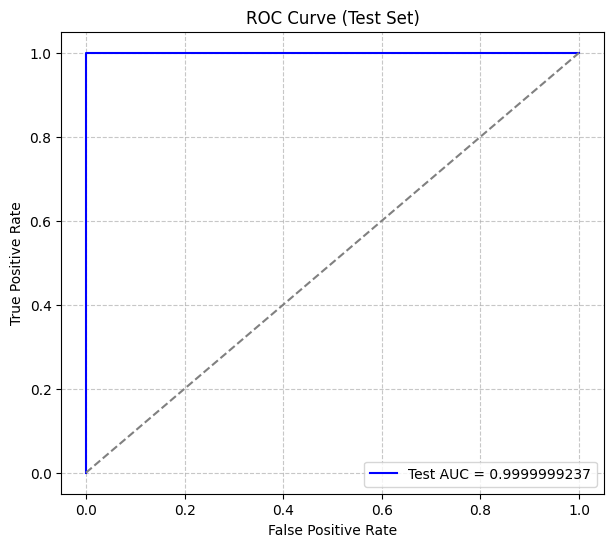

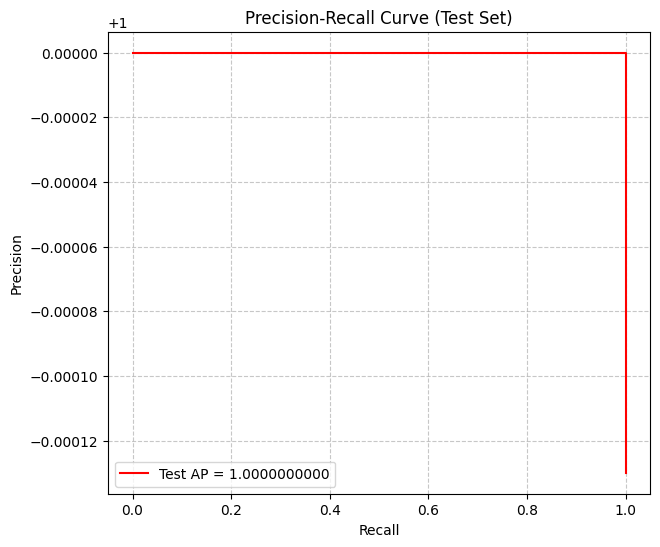

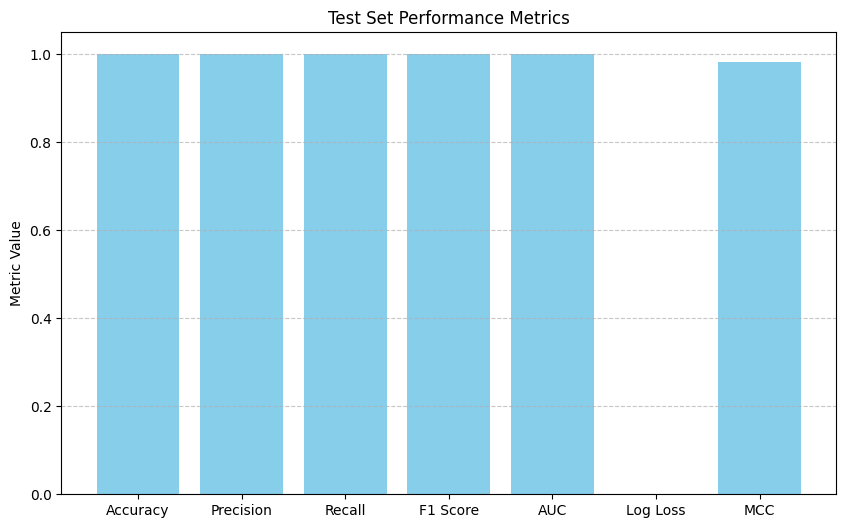

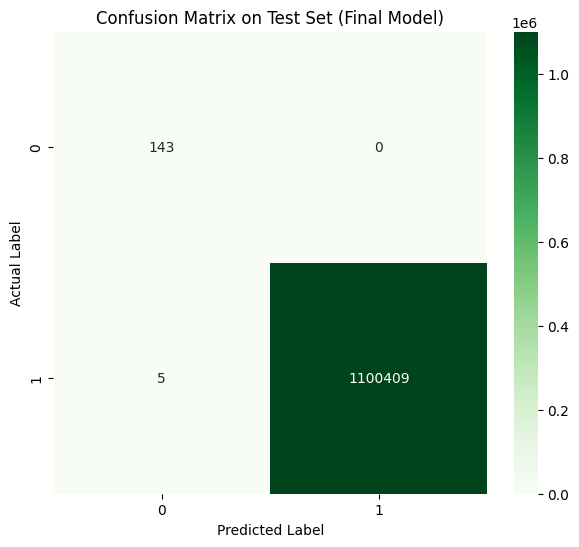

In [ ]:
#  Model Training and Evaluation 

# --- Data Availability Check ---
required_variables_map = {
    'X_train': "Training features ( after encoding, pre-scaling, pre-SMOTE)",
    'y_train': "Training labels (e.g., from Cell 4, pre-SMOTE)",
    'X_test': "Test features (e.g., from Cell 4 after encoding, pre-scaling)",
    'y_test': "Test labels (e.g., from Cell 4, for final evaluation)",
    'selected_feature_indices': "NumPy array of feature indices selected by GA (e.g., from Cell 6)",
    'selected_feature_names': "List of feature names selected by GA (e.g., from Cell 6)"
}
missing_variables = []
for var_name in required_variables_map.keys():
    if var_name not in locals():
        missing_variables.append(var_name)
if missing_variables:
    error_message = "CRITICAL ERROR: The following required data variables are not defined in the current scope.\n"
    error_message += "Please ensure they are correctly loaded or passed from the preceding cells in your notebook.\n"
    for var_name in missing_variables:
        error_message += f"  - Missing variable: '{var_name}' (Expected: {required_variables_map[var_name]})\n"
    raise ValueError(error_message)

export_dir = "model_export_cell7" 
os.makedirs(export_dir, exist_ok=True)

# === STEP 1: Scaling using MinMaxScaler ===
print("\n--- STEP 1: Scaling Original Data (X_train, X_test) ---")
scaler = MinMaxScaler()
X_train_full_scaled_for_final_model = scaler.fit_transform(X_train)
X_test_full_scaled_for_final_model = scaler.transform(X_test)
try:
    assert hasattr(scaler, 'min_') and scaler.min_ is not None, "Scaler 'min_' attribute not learned."
    assert hasattr(scaler, 'scale_') and scaler.scale_ is not None, "Scaler 'scale_' attribute not learned."
    if X_train.shape[1] > 0:
        column_means = X_train.mean().values if isinstance(X_train, pd.DataFrame) else np.mean(X_train, axis=0)
        dummy_sample_orig = column_means.reshape(1, -1)
        scaled_dummy = scaler.transform(dummy_sample_orig)
        assert np.all(scaled_dummy >= 0) and np.all(scaled_dummy <= 1), "Scaled dummy sample is not within [0, 1] range."
except Exception as e:
    print(f"VALIDATION FAILED: Scaler Behavior Test. Error: {e}")
    raise
scaler_path = os.path.join(export_dir, "scaler_final_model.pkl")
joblib.dump(scaler, scaler_path)
print(f"  Scaler for final model saved to: {scaler_path}")

# === LightGBM Params ===
lgb_params = {
    "learning_rate": 0.061973344708344064, 
    "num_leaves": 28,
    "max_depth": 11,
    "min_child_samples": 90,
    "subsample": 0.892584950769231,
    "colsample_bytree": 0.9745211515782148,
    "reg_alpha": 5.972876500404733e-06,
    "reg_lambda": 1.4804955907016756e-08,
    "n_estimators": 219, 
    "verbose": -1,
    "random_state": 42 
}

# === Prepare training and test data with GA-selected features ===
print("\n--- Applying GA-Selected Features to Scaled Original Data ---")
X_train_final_ga = X_train_full_scaled_for_final_model[:, selected_feature_indices]
y_train_final_labels = np.array(y_train) 
X_test_final_ga = X_test_full_scaled_for_final_model[:, selected_feature_indices]
y_test_final_labels = np.array(y_test) 

try:
    assert X_train_final_ga.shape[1] == len(selected_feature_indices), "Mismatch in X_train_final_ga features and GA selection count."
    assert X_test_final_ga.shape[1] == len(selected_feature_indices), "Mismatch in X_test_final_ga features and GA selection count."
    assert X_train_final_ga.shape[1] == len(selected_feature_names), "Mismatch between number of selected indices and selected feature names."
except AssertionError as e:
    print(f"VALIDATION FAILED: Feature Selection Consistency Test. Error: {e}")
    raise

np.save(os.path.join(export_dir, "selected_features_indices_final.npy"), selected_feature_indices)
with open(os.path.join(export_dir, "selected_feature_names_final.json"), "w") as f:
    json.dump(selected_feature_names, f)

# === 5-Fold Cross-Validation ===
from sklearn.metrics import matthews_corrcoef
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results_cv = []
oof_preds_proba_cv = np.zeros(X_train_final_ga.shape[0])
cv_val_indices_all = []
print("\n--- Starting 5-Fold Cross-Validation ---")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_final_ga, y_train_final_labels), 1):
    X_train_fold, X_val_fold = X_train_final_ga[train_idx], X_train_final_ga[val_idx]
    y_train_fold, y_val_fold = y_train_final_labels[train_idx], y_train_final_labels[val_idx]
    cv_val_indices_all.extend(val_idx)
    assert len(set(train_idx).intersection(set(val_idx))) == 0, f"Fold {fold} has overlapping train/validation indices! Potential leakage."
    model_cv = lgb.LGBMClassifier(**lgb_params, class_weight="balanced")
    model_cv.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric="binary_logloss", 
        feature_name=selected_feature_names, 
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=-1)]
    )
    y_pred_val_cv = model_cv.predict(X_val_fold)
    y_pred_proba_val_cv = model_cv.predict_proba(X_val_fold)[:, 1]
    oof_preds_proba_cv[val_idx] = y_pred_proba_val_cv
    mcc_cv = matthews_corrcoef(y_val_fold, y_pred_val_cv)
    current_fold_metrics = {
        "Fold": fold, 
        "Accuracy": accuracy_score(y_val_fold, y_pred_val_cv),
        "Precision": precision_score(y_val_fold, y_pred_val_cv, average="weighted", zero_division=0),
        "Recall": recall_score(y_val_fold, y_pred_val_cv, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_val_fold, y_pred_val_cv, average="weighted", zero_division=0),
        "AUC Score": roc_auc_score(y_val_fold, y_pred_proba_val_cv),
        "Log Loss": log_loss(y_val_fold, y_pred_proba_val_cv),
        "MCC Score": mcc_cv,
        "Confusion Matrix": confusion_matrix(y_val_fold, y_pred_val_cv),
        "Best Iteration": model_cv.best_iteration_
    }
    print(f"  Fold {fold}: Acc={current_fold_metrics['Accuracy']:.10f}, Prc={current_fold_metrics['Precision']:.10f}, Rec={current_fold_metrics['Recall']:.10f}, F1={current_fold_metrics['F1 Score']:.10f}, AUC={current_fold_metrics['AUC Score']:.10f}, MCC={current_fold_metrics['MCC Score']:.10f}, BestIter={current_fold_metrics['Best Iteration']}")
    print(f"    Fold {fold} Confusion Matrix:\n{current_fold_metrics['Confusion Matrix']}")
    fold_results_cv.append(current_fold_metrics)

try:
    assert len(set(cv_val_indices_all)) == X_train_final_ga.shape[0], "CV validation folds do not perfectly cover the training set without duplicates."
except AssertionError as e:
    print(f"VALIDATION FAILED: CV Split Integrity Test. Error: {e}")
    raise

if fold_results_cv:
    avg_metrics_cv = {
        metric: np.mean([f[metric] for f in fold_results_cv if metric not in ["Confusion Matrix", "Fold"]])
        for metric in fold_results_cv[0].keys() if metric not in ["Confusion Matrix", "Fold"]
    }
    avg_cm_cv_matrix = np.mean(np.array([f["Confusion Matrix"] for f in fold_results_cv]), axis=0).astype(int)
    print("\n--- Average Metrics Across All Folds (Cross-Validation) ---")
    for k, v in avg_metrics_cv.items():
        print(f"  {k}: {v:.10f}") 
    print("  Average Confusion Matrix (Cross-Validation):")
    print(avg_cm_cv_matrix)
else:
    print("  WARNING: No CV fold results to average.")
    avg_cm_cv_matrix = np.zeros((2,2), dtype=int)

# --- Final Model Training with Early Stopping ---
print("\n--- Training Final Model on Full Prepared Training Data with Early Stopping ---")
X_train_final_model_train, X_train_final_model_val, \
y_train_final_model_train, y_train_final_model_val = train_test_split(
    X_train_final_ga, y_train_final_labels, test_size=0.15, stratify=y_train_final_labels, random_state=42
)
final_model = lgb.LGBMClassifier(**lgb_params, class_weight="balanced")
eval_result_log_final_model = {}
final_model.fit(
    X_train_final_model_train, y_train_final_model_train,
    eval_set=[(X_train_final_model_val, y_train_final_model_val)],
    eval_metric="binary_logloss",
    feature_name=selected_feature_names,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30, verbose=-1),
        lgb.log_evaluation(period=0),
        lgb.record_evaluation(eval_result_log_final_model)
    ]
)
print(f"  Final model trained. Best iteration: {final_model.best_iteration_ if final_model.best_iteration_ else 'N/A'}")
model_path_cell7 = os.path.join(export_dir, "ids_lightgbm_final_model.pkl")
joblib.dump(final_model, model_path_cell7)
print(f"  Final model saved to: {model_path_cell7}")

# === Final Evaluation on the Unseen Test Set (Important!) ===
print("\n--- Evaluating Final Model on the Unseen Test Set ---")
y_pred_test_final_model = final_model.predict(X_test_final_ga)
y_pred_proba_test_final_model = final_model.predict_proba(X_test_final_ga)[:, 1]
test_accuracy_final_model = accuracy_score(y_test_final_labels, y_pred_test_final_model)
test_precision_final_model = precision_score(y_test_final_labels, y_pred_test_final_model, average="weighted", zero_division=0)
test_recall_final_model = recall_score(y_test_final_labels, y_pred_test_final_model, average="weighted", zero_division=0)
test_f1_final_model = f1_score(y_test_final_labels, y_pred_test_final_model, average="weighted", zero_division=0)
try:
    test_auc_final_model = roc_auc_score(y_test_final_labels, y_pred_proba_test_final_model)
    test_logloss_final_model = log_loss(y_test_final_labels, y_pred_proba_test_final_model)
except ValueError as e:
    print(f"  WARNING: Could not calculate AUC/LogLoss on test set: {e}")
    test_auc_final_model = float('nan')
    test_logloss_final_model = float('nan')
test_mcc_final = matthews_corrcoef(y_test_final_labels, y_pred_test_final_model)
print(f"  Test Accuracy: {test_accuracy_final_model:.10f}") 
print(f"  Test Precision: {test_precision_final_model:.10f}")
print(f"  Test Recall: {test_recall_final_model:.10f}")
print(f"  Test F1 Score: {test_f1_final_model:.10f}")
print(f"  Test AUC Score: {test_auc_final_model:.10f}")
print(f"  Test Log Loss: {test_logloss_final_model:.10f}")
print(f"  Test MCC: {test_mcc_final:.10f}")
cm_test_final_model_matrix = confusion_matrix(y_test_final_labels, y_pred_test_final_model)

# --- Test Set Visualizations ---
# Test Set ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test_final_labels, y_pred_proba_test_final_model)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure(figsize=(7, 6))
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.10f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Test Set Precision-Recall Curve
precision_test, recall_test, _ = precision_recall_curve(y_test_final_labels, y_pred_proba_test_final_model)
pr_auc_test = auc(recall_test, precision_test)
plt.figure(figsize=(7, 6))
plt.plot(recall_test, precision_test, label=f"Test AP = {pr_auc_test:.10f}", color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test Set)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Bar Chart for Test Set Performance Metrics (including MCC)
test_metrics = {
    "Accuracy": test_accuracy_final_model,
    "Precision": test_precision_final_model,
    "Recall": test_recall_final_model,
    "F1 Score": test_f1_final_model,
    "AUC": test_auc_final_model,
    "Log Loss": test_logloss_final_model,
    "MCC": test_mcc_final
}
plt.figure(figsize=(10, 6))
plt.bar(test_metrics.keys(), test_metrics.values(), color="skyblue")
plt.ylabel("Metric Value")
plt.title("Test Set Performance Metrics")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Test Set Confusion Matrix Heatmap (Final Model)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_test_final_model_matrix, annot=True, fmt="d", cmap="Greens", cbar=True,
            xticklabels=final_model.classes_ if hasattr(final_model, 'classes_') else [0,1],
            yticklabels=final_model.classes_ if hasattr(final_model, 'classes_') else [0,1])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix on Test Set (Final Model)")
plt.show()



--- Starting ToN_IoT Data Processing and Cross-Validation ---
Found 2 CSV files for processing.
Loaded C:\VS code projects\data_files\ton_iot\Network_dataset_1.csv with shape (1000000, 40)
Loaded C:\VS code projects\data_files\ton_iot\Network_dataset_2.csv with shape (1000000, 40)
Concatenated ToN_IoT data shape: (2000000, 40)
X shape before encoding: (2000000, 39)
Target unique values before mapping: [0 1]
Target unique values after mapping: [0 1]
No missing values remain in features.
Dropping high-cardinality column src_bytes with 2845 unique values.
Dropping high-cardinality column dns_query with 1543 unique values.
Dropping high-cardinality column http_uri with 138 unique values.
One-hot encoding columns: ['proto', 'service', 'conn_state', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_referrer', 'http_version', 'http_user_agent', 'http_orig_mime_types

c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00779281


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 1 metrics: {'Fold': 1, 'Accuracy': 0.998825, 'Precision': 0.9988358733648722, 'Recall': 0.998825, 'F1 Score': 0.9988275413581887, 'AUC Score': np.float64(0.9999680583988344), 'Log Loss': 0.007792814328643734, 'MCC Score': np.float64(0.9939032442210993), 'Confusion Matrix': array([[ 42857,     23],
       [   447, 356673]]), 'Best Iteration': 100}

Training fold 2...


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00771797


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 2 metrics: {'Fold': 2, 'Accuracy': 0.9986625, 'Precision': 0.998676497293078, 'Recall': 0.9986625, 'F1 Score': 0.9986657793011496, 'AUC Score': np.float64(0.9999768462613419), 'Log Loss': 0.007717971457139362, 'MCC Score': np.float64(0.993066190438611), 'Confusion Matrix': array([[ 42852,     27],
       [   508, 356613]]), 'Best Iteration': 100}

Training fold 3...


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00805929


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 3 metrics: {'Fold': 3, 'Accuracy': 0.9986, 'Precision': 0.9986147089183278, 'Recall': 0.9986, 'F1 Score': 0.9986034963447386, 'AUC Score': np.float64(0.9999655472279956), 'Log Loss': 0.008059286947731536, 'MCC Score': np.float64(0.9927426653311449), 'Confusion Matrix': array([[ 42844,     35],
       [   525, 356596]]), 'Best Iteration': 100}

Training fold 4...


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00827878


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 4 metrics: {'Fold': 4, 'Accuracy': 0.9985725, 'Precision': 0.9985879459550909, 'Recall': 0.9985725, 'F1 Score': 0.9985761589686915, 'AUC Score': np.float64(0.9999612864994107), 'Log Loss': 0.008278781300858276, 'MCC Score': np.float64(0.9926017734210347), 'Confusion Matrix': array([[ 42845,     34],
       [   537, 356584]]), 'Best Iteration': 100}

Training fold 5...


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0080035


c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Spencer Kanjera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 5 metrics: {'Fold': 5, 'Accuracy': 0.998635, 'Precision': 0.9986498985779667, 'Recall': 0.998635, 'F1 Score': 0.9986384642213858, 'AUC Score': np.float64(0.9999711544929631), 'Log Loss': 0.008003497997623859, 'MCC Score': np.float64(0.9929258443901255), 'Confusion Matrix': array([[ 42855,     24],
       [   522, 356599]]), 'Best Iteration': 100}

--- Average Cross-Validation Metrics ---
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F1 Score: 0.9987
AUC Score: 1.0000
Log Loss: 0.0080
MCC Score: 0.9930
Best Iteration: 100.0000
Average Confusion Matrix:
[[ 42850     28]
 [   507 356613]]


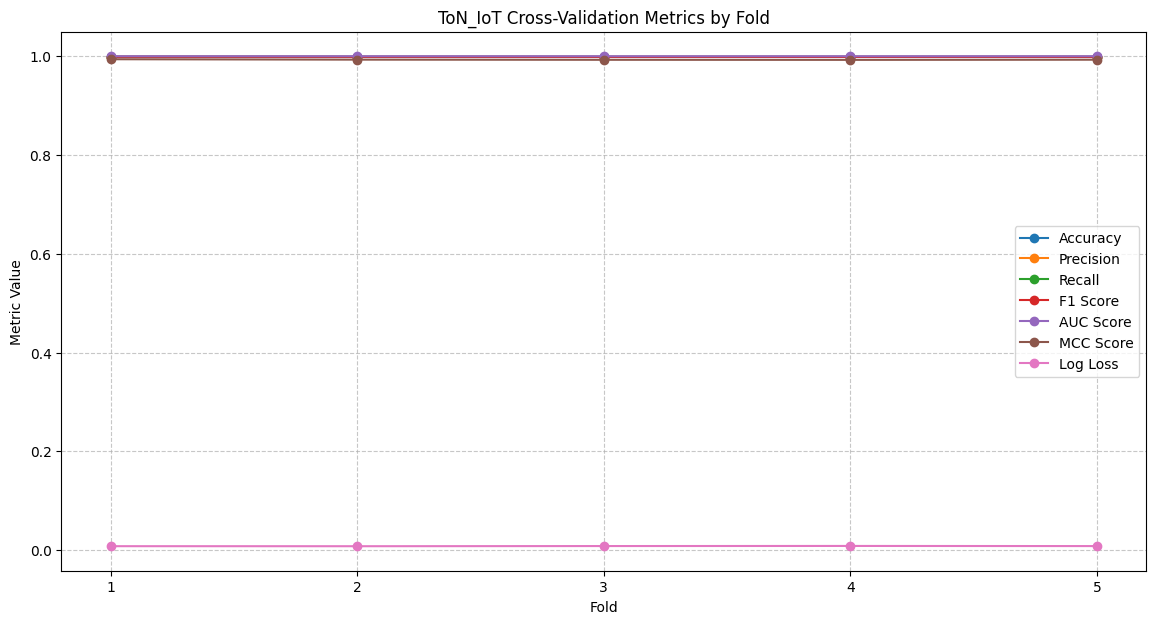

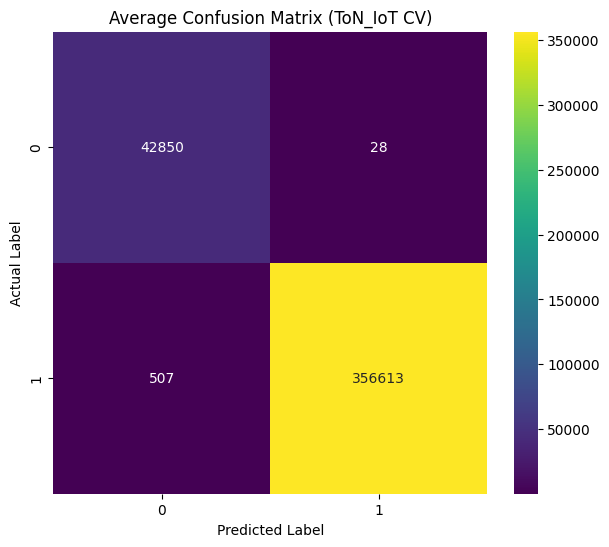


--- ToN_IoT Cross-Validation Complete ---


In [ ]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, log_loss, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold

# --- Configuration for ToN_IoT Dataset ---
TON_IOT_DATA_FOLDER = r"C:\VS code projects\data_files\ton_iot"
TON_IOT_TARGET_COLUMN_NAME = 'label'
TON_IOT_FEATURES_TO_USE = [
    'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 
    'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 
    'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 
    'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 
    'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 
    'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 
    'http_referrer', 'http_version', 'http_request_body_len', 
    'http_response_body_len', 'http_status_code', 'http_user_agent', 
    'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 
    'weird_addl', 'weird_notice'
]
MAX_CATEGORIES_FOR_OHE = 100

# Default LightGBM parameters
lgb_params = {
    "learning_rate": 0.05,
    "n_estimators": 100,
    "random_state": 42,
    "verbose": -1,
    "num_leaves": 31,
    "max_depth": -1,
    "min_child_samples": 20,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0
}

def sanitize_feature_names(feature_names):
    """
    Sanitizes feature names to be compatible with LightGBM.
    Replaces JSON special characters and spaces with underscores.
    Ensures names are unique after sanitization.
    """
    sanitized_names = []
    seen_names = {}
    for name in feature_names:
        name = str(name)
        name = re.sub(r'[\[\]{}:",\s]', '_', name)
        original_name = name
        count = 0
        while name in seen_names:
            count += 1
            name = f"{original_name}_{count}"
        seen_names[name] = True
        sanitized_names.append(name)
    return sanitized_names

print("--- Starting ToN_IoT Data Processing and Cross-Validation ---")

# === STEP 1: Load Data from ToN_IoT CSV Files ===
if not os.path.isdir(TON_IOT_DATA_FOLDER):
    raise FileNotFoundError(f"ToN_IoT data folder not found: {TON_IOT_DATA_FOLDER}")

file_list = glob.glob(os.path.join(TON_IOT_DATA_FOLDER, "*.csv"))
if not file_list:
    raise FileNotFoundError(f"No CSV files found in folder: {TON_IOT_DATA_FOLDER}")
print(f"Found {len(file_list)} CSV files for processing.")

# Combine features and target into one list of columns to load
columns_to_load = sorted(list(set(TON_IOT_FEATURES_TO_USE + [TON_IOT_TARGET_COLUMN_NAME])))

dfs = []
for file_path in file_list:
    try:
        df_header = pd.read_csv(file_path, nrows=0, low_memory=False)
        actual_cols = [col for col in columns_to_load if col in df_header.columns]
        if not actual_cols or TON_IOT_TARGET_COLUMN_NAME not in actual_cols:
            print(f"Skipping file (missing target or features): {file_path}")
            continue
        df_tmp = pd.read_csv(file_path, usecols=actual_cols, low_memory=False)
        dfs.append(df_tmp)
        print(f"Loaded {file_path} with shape {df_tmp.shape}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

if not dfs:
    raise ValueError("No dataframes loaded. Check CSV files and column names.")

df_ton = pd.concat(dfs, ignore_index=True)
print(f"Concatenated ToN_IoT data shape: {df_ton.shape}")

# Ensure every expected column exists (add missing ones as NaN)
for col in columns_to_load:
    if col not in df_ton.columns:
        print(f"Warning: {col} missing, adding as NaN")
        df_ton[col] = np.nan

# === STEP 2: Target Variable Preparation ===
if TON_IOT_TARGET_COLUMN_NAME not in df_ton.columns:
    raise ValueError(f"Target column '{TON_IOT_TARGET_COLUMN_NAME}' not found.")

y = df_ton[TON_IOT_TARGET_COLUMN_NAME]
X = df_ton.drop(columns=[TON_IOT_TARGET_COLUMN_NAME])

# Use only the features that are available
loaded_features = [f for f in TON_IOT_FEATURES_TO_USE if f in X.columns]
X = X[loaded_features]
print(f"X shape before encoding: {X.shape}")
print(f"Target unique values before mapping: {y.unique()[:20]}")

# Map target: convert 'Normal' and 'Benign' (case-insensitive) to 0; everything else becomes 1.
y = y.replace(['Normal', 'normal', 'Benign', 'benign'], 0).fillna(-1)
y = y.apply(lambda x: 1 if (x != 0 and x != -1) else (0 if x == 0 else -1)).astype(int)
valid_idx = y[y != -1].index
y = y.loc[valid_idx]
X = X.loc[valid_idx]
print(f"Target unique values after mapping: {np.unique(y)}")
if X.empty or y.empty:
    raise ValueError("Data empty after target processing.")

# === STEP 3: Preprocessing Features ===
for col in X.columns:
    if X[col].isnull().any():
        if pd.api.types.is_numeric_dtype(X[col]):
            X[col].fillna(X[col].median(), inplace=True)
        else:
            mode_val = X[col].mode()
            X[col].fillna(mode_val[0] if not mode_val.empty else "Unknown", inplace=True)
if X.isnull().sum().sum() == 0:
    print("No missing values remain in features.")

# Drop high-cardinality categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
cols_to_drop = []
for col in categorical_cols:
    if X[col].nunique() > MAX_CATEGORIES_FOR_OHE:
        print(f"Dropping high-cardinality column {col} with {X[col].nunique()} unique values.")
        cols_to_drop.append(col)
if cols_to_drop:
    X.drop(columns=cols_to_drop, inplace=True)

# One-hot encode remaining categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    print(f"One-hot encoding columns: {categorical_cols}")
    X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False, dtype=int)
    print(f"X shape after one-hot encoding: {X.shape}")
else:
    print("No categorical columns to one-hot encode.")

# Convert any remaining non-numeric columns
non_numeric = X.select_dtypes(exclude=np.number).columns
if len(non_numeric) > 0:
    print(f"Converting non-numeric columns: {non_numeric.tolist()}")
    for col in non_numeric:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    if X.select_dtypes(exclude=np.number).shape[1] > 0:
        raise TypeError("Not all columns were converted to numeric.")

# Sanitize feature names for LightGBM
original_feature_names = X.columns.tolist()
final_feature_names = sanitize_feature_names(original_feature_names)
X.columns = final_feature_names
print(f"Number of features after sanitization: {len(final_feature_names)}")

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_prepared = np.array(y)

# === STEP 4: 5-Fold Stratified Cross-Validation ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []
print("\nStarting 5-Fold Cross-Validation on ToN_IoT data...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y_prepared), 1):
    print(f"\nTraining fold {fold}...")
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y_prepared[train_idx], y_prepared[val_idx]
    
    model_cv = lgb.LGBMClassifier(**lgb_params, class_weight="balanced")
    model_cv.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric="binary_logloss",
        feature_name=final_feature_names,
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=-1)]
    )
    
    y_pred = model_cv.predict(X_val_fold)
    y_pred_proba = model_cv.predict_proba(X_val_fold)[:, 1]
    
    fold_metrics = {
        "Fold": fold,
        "Accuracy": accuracy_score(y_val_fold, y_pred),
        "Precision": precision_score(y_val_fold, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_val_fold, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_val_fold, y_pred, average="weighted", zero_division=0),
        "AUC Score": roc_auc_score(y_val_fold, y_pred_proba),
        "Log Loss": log_loss(y_val_fold, y_pred_proba),
        "MCC Score": matthews_corrcoef(y_val_fold, y_pred),
        "Confusion Matrix": confusion_matrix(y_val_fold, y_pred),
        "Best Iteration": model_cv.best_iteration_
    }
    print(f"Fold {fold} metrics: {fold_metrics}")
    fold_results.append(fold_metrics)

# Compute average metrics across folds
if fold_results:
    avg_metrics = {metric: np.mean([f[metric] for f in fold_results if metric not in ["Confusion Matrix", "Fold"]])
                   for metric in fold_results[0].keys() if metric not in ["Confusion Matrix", "Fold"]}
    avg_cm_matrix = np.mean(np.array([f["Confusion Matrix"] for f in fold_results]), axis=0).astype(int)
    print("\n--- Average Cross-Validation Metrics ---")
    for k, v in avg_metrics.items():
        print(f"{k}: {v:.4f}")
    print("Average Confusion Matrix:")
    print(avg_cm_matrix)
else:
    print("No CV fold results available.")
    avg_metrics = {}
    avg_cm_matrix = np.zeros((2,2), dtype=int)

# === STEP 5: Visualizations ===
# Plot per-fold metrics for Accuracy, Precision, Recall, F1, AUC, MCC, and Log Loss.
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "MCC Score", "Log Loss"]
folds = [f["Fold"] for f in fold_results]

plt.figure(figsize=(14, 7))
for metric in metrics_to_plot:
    values = [f[metric] for f in fold_results]
    plt.plot(folds, values, marker="o", label=metric)
plt.xlabel("Fold")
plt.ylabel("Metric Value")
plt.xticks(folds)
plt.title("ToN_IoT Cross-Validation Metrics by Fold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Plot average confusion matrix as a heatmap.
plt.figure(figsize=(7, 6))
class_labels = model_cv.classes_ if hasattr(model_cv, 'classes_') else [0, 1]
sns.heatmap(avg_cm_matrix, annot=True, fmt="d", cmap="viridis", cbar=True,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Average Confusion Matrix (ToN_IoT CV)")
plt.show()

print("\n--- ToN_IoT Cross-Validation Complete ---")